In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data, create_feature_df
from generate_anomalies import generate_single_anomaly, generate_short_term_anomaly, generate_long_term_anomaly
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calc_precision, calc_recall, calc_f1_score
import gc
from tqdm import tqdm_notebook
from functools import reduce
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Loading data

In [2]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]

raw = load_mm94_stations(train_station_id + test_station_id + generate_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)
train_clean = get_clean_data(train)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)
test['label_true'] = get_labels(test, labels_type='true')

generated = data[data['station_id'].isin(generate_station_id)]
generated = generated.reset_index(drop=True)
generated_clean = get_clean_data(generated)

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

CPU times: user 2min 5s, sys: 14.1 s, total: 2min 19s
Wall time: 2min 19s


## Generate anomalies

In [3]:
np.random.seed(42)
to_generate = copy(generated_clean)
to_generate['label_true'] = False
col = MmxColumns.ROAD_TEMPERATURE

#---------------------------------------------------------------------------------
number_of_anomalies = 30 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_single_anomaly(to_generate, index)
    to_generate.loc[index, col] += perturbated_series
    to_generate.loc[index, 'label_true'] = True
    
#---------------------------------------------------------------------------------
number_of_anomalies = 20 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_short_term_anomaly(to_generate, index)
    series_duration = len(perturbated_series)
    to_generate.loc[index: (index + series_duration - 1), col] += perturbated_series
    to_generate.loc[index: (index + series_duration - 1), 'label_true'] = True

#---------------------------------------------------------------------------------
number_of_anomalies = 3 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_long_term_anomaly(to_generate, index)
    series_duration = len(perturbated_series)
    to_generate.loc[index: (index + series_duration - 1), col] += perturbated_series
    to_generate.loc[index: (index + series_duration - 1), 'label_true'] = True

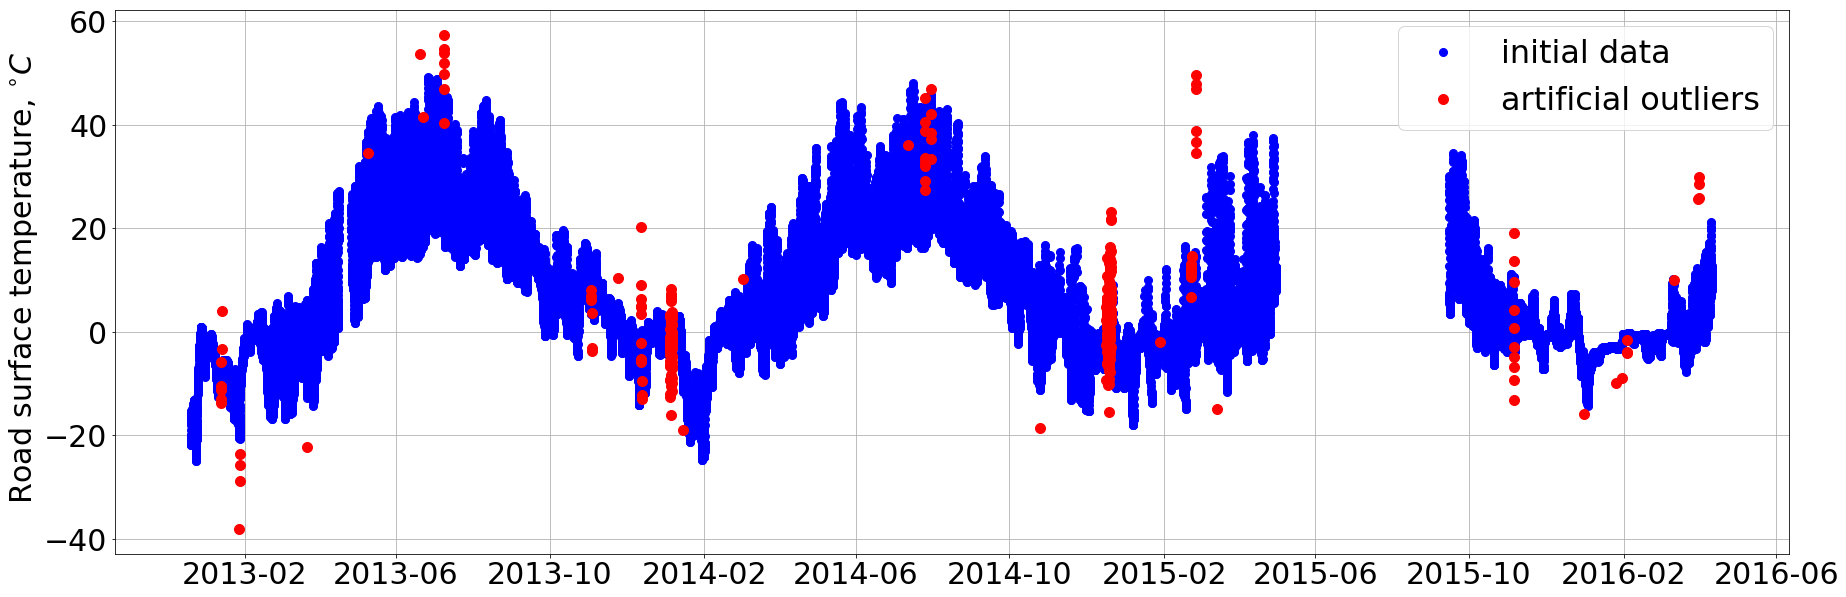

In [4]:
start = pd.Timestamp(2012, 12, 20)
end = pd.Timestamp(2017, 1, 27)

to_plot = to_generate[to_generate['station_id']==615]
to_plot = to_plot[(to_plot['date_time_utc']<=end) & (to_plot['date_time_utc']>=start)]
to_plot = to_plot.set_index('date_time_utc')


plt.figure(figsize=(30, 10))

for elem in [False, True]:
    cond = to_plot['label_true'] == elem
    if elem:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'r',
                      linestyle='none', marker='o', markersize=10, label='artificial outliers')
    else:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='initial data')

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Road surface temperature, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()

## Elliptic Envelope

In [5]:
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score

point = pd.Timestamp(2015, 6, 1)

time = 0
lag_list=(1, 2, 3)
diff_list=((1, 2), (1, 3))
variables = ['data_t_road'] #, 'data_t_air', 'data_t_underroad']
road_id = False
coordinates = False
post_process = False
regression_mode = False


df_generate = create_feature_df(to_generate, winter_period=False, time=time, lag_list=lag_list, 
                                diff_list=diff_list, post_process=post_process, 
                                road_id=road_id, coordinates=coordinates, variables=variables, )
df_train = create_feature_df(train, winter_period=False, time=time, lag_list=lag_list, 
                               diff_list=diff_list, post_process=post_process,
                            road_id=road_id, coordinates=coordinates, variables=variables,)
df_train_clean = create_feature_df(train_clean, winter_period=False, time=time, lag_list=lag_list, 
                                   diff_list=diff_list, post_process=post_process, 
                                    road_id=road_id, coordinates=coordinates, variables=variables,)
df_test = create_feature_df(test, winter_period=False, time=time, lag_list=lag_list, 
                            diff_list=diff_list, post_process=post_process, 
                           road_id=road_id, coordinates=coordinates, variables=variables)

features = [col for col in df_generate if col.startswith('data_')]
target = [col for col in df_generate if col.startswith('target_')][0]

features.append(target)

clf = EllipticEnvelope(contamination=0.001)
features_sample_list = []
scaler = MinMaxScaler()
iterations = 10

In [6]:
for i in range(iterations):
    # Generate data set 
    sample_size = np.random.randint(2 , len(features) // 1.5)
    features_sample = np.random.choice(features, sample_size)

    X_train_clean = df_train_clean.loc[:, features_sample].values
    #y_train_clean = df_train_clean['label_true'].values

    X_train = df_train.loc[:, features_sample].values
    #y_train = df_train['label_true'].values

    X_test = df_generate.loc[:, features_sample].values
    y_test = df_generate['label_true'].values
    
    # Train model
    clf.fit(X_train)
    
    # Save model
    features_sample_list.append((copy(clf), features_sample))
    
    # Predict
    y_pred =  (1 - clf.predict(X_test)) / 2
    df_generate['decision_function_{0}'.format(i)] = - clf.decision_function(X_test)
    
    # F1
    f1 = f1_score(y_test, y_pred, pos_label=0)
    
    print('{0} {1} -- {2:.4f}'.format(i, sample_size, f1))
    #print('{0:.2f} {1:.4f}'.format(thresh_opt, f1_opt))
    #print('{0:.3f}'.format(roc_auc))
    print('----------------------------------------------')

0 6 -- 0.9961
----------------------------------------------
1 5 -- 0.9967
----------------------------------------------
2 6 -- 0.9961
----------------------------------------------
3 6 -- 0.9967
----------------------------------------------
4 3 -- 0.9952
----------------------------------------------
5 3 -- 0.9951
----------------------------------------------
6 5 -- 0.9967
----------------------------------------------
7 4 -- 0.9959
----------------------------------------------
8 5 -- 0.9960
----------------------------------------------
9 4 -- 0.9967
----------------------------------------------


In [7]:
scaler_1 = MinMaxScaler()
st_id = generate_station_id
window = pd.Timedelta('4h')

alg_cols = [col for col in df_generate.columns if col.startswith('decision_function_')]
df = copy(df_generate[alg_cols + ['label_true', 'station_id', 'date_time_utc', 'target_t_road']])
df['decision_function'] = 0

for i in range(iterations):
    df['decision_function'] += df['decision_function_{0}'.format(i)]
    
df['decision_function'] = scaler_1.fit_transform(df['decision_function'].values.reshape(-1, 1))

In [8]:
generated_results = []

for thresh in np.arange(0.15, 0.25, 0.005):
    df['label_predict'] = df['decision_function'] > thresh
        
    recall = calc_recall(df, st_id, window)
    precision = calc_precision(df, st_id, window)
    f1 = calc_f1_score(precision, recall)
    
    generated_results.append({'Threshold': thresh, 'Recall': recall, 'Precision': precision, 'F1': f1})
    print("Threshhold: {0:.4f} -- {1:.3f}".format(thresh, f1))
    #print("Recall: {0:.3f} \nPrecision: {1:.3f} \nF1:{2:.3f}".format(recall, precision, f1_score))
    print("----------------------------------------")

Threshhold: 0.1500 -- 0.958
----------------------------------------
Threshhold: 0.1550 -- 0.960
----------------------------------------
Threshhold: 0.1600 -- 0.960
----------------------------------------
Threshhold: 0.1650 -- 0.960
----------------------------------------
Threshhold: 0.1700 -- 0.963
----------------------------------------
Threshhold: 0.1750 -- 0.964
----------------------------------------
Threshhold: 0.1800 -- 0.965
----------------------------------------
Threshhold: 0.1850 -- 0.964
----------------------------------------
Threshhold: 0.1900 -- 0.962
----------------------------------------
Threshhold: 0.1950 -- 0.960
----------------------------------------
Threshhold: 0.2000 -- 0.958
----------------------------------------
Threshhold: 0.2050 -- 0.957
----------------------------------------
Threshhold: 0.2100 -- 0.955
----------------------------------------
Threshhold: 0.2150 -- 0.954
----------------------------------------
Threshhold: 0.2200 -- 0.952
------

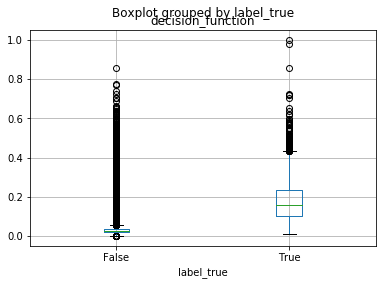

In [9]:
%matplotlib inline

df[df['decision_function']<10].boxplot('decision_function', 'label_true')

## Real data

In [10]:
for i in range(iterations):
    # Generate data set 
    #sample_size = np.random.randint(len(features) // 2, len(features) - 1)
    #features_sample = np.random.choice(features, sample_size)
    
    features_sample = features_sample_list[i][1]
    sample_size = len(features_sample)

    X_test = df_test.loc[:, features_sample].values
    y_test = df_test['label_true'].values
    
    # Train model
    clf = features_sample_list[i][0]
    
    # Save model
    #features_sample_list.append((copy(regr), features_sample))
    
    # Predict
    y_pred = (1 - clf.predict(X_test)) / 2
    df_test['decision_function_{0}'.format(i)] = -clf.decision_function(X_test)
    
    # F1
    f1 = f1_score(y_test, y_pred, pos_label=0)
    
    print('{0} {1} -- {2:.4f}'.format(i, sample_size, f1))
    #print('{0:.2f} {1:.4f}'.format(thresh_opt, f1_opt))
    #print('{0:.3f}'.format(roc_auc))
    print('----------------------------------------------')

0 6 -- 0.9949
----------------------------------------------
1 5 -- 0.9950
----------------------------------------------
2 6 -- 0.9949
----------------------------------------------
3 6 -- 0.9950
----------------------------------------------
4 3 -- 0.9941
----------------------------------------------
5 3 -- 0.9941
----------------------------------------------
6 5 -- 0.9950
----------------------------------------------
7 4 -- 0.9950
----------------------------------------------
8 5 -- 0.9949
----------------------------------------------
9 4 -- 0.9950
----------------------------------------------


In [11]:
st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
scaler_2 = MinMaxScaler()
window = pd.Timedelta('4h')

alg_cols = [col for col in df_test.columns if col.startswith('decision_function_')]
df_1 = copy(df_test[alg_cols + ['label_true', 'station_id', 'date_time_utc', 'target_t_road']])
df_1['decision_function'] = 0

for i in range(iterations):
    df_1['decision_function'] += df_1['decision_function_{0}'.format(i)]
    
df_1['decision_function'] = scaler_1.transform(df_1['decision_function'].values.reshape(-1, 1))

real_results = []

for thresh in np.arange(0.15, 0.25, 0.005):
    df_1['label_predict'] = df_1['decision_function'] > thresh
        
    recall = calc_recall(df_1, st_id, window)
    precision = calc_precision(df_1, st_id, window)
    f1 = calc_f1_score(precision, recall)
    
    real_results.append({'Threshold': thresh, 'Recall': recall, 'Precision': precision, 'F1': f1})
    print("Threshhold: {0:.3f} -- {1:.3f}".format(thresh, f1))
    #print("Recall: {0:.3f} \nPrecision: {1:.3f} \nF1:{2:.3f}".format(recall, precision, f1_score))
    print("----------------------------------------")

Threshhold: 0.150 -- 0.632
----------------------------------------
Threshhold: 0.155 -- 0.659
----------------------------------------
Threshhold: 0.160 -- 0.672
----------------------------------------
Threshhold: 0.165 -- 0.691
----------------------------------------
Threshhold: 0.170 -- 0.697
----------------------------------------
Threshhold: 0.175 -- 0.706
----------------------------------------
Threshhold: 0.180 -- 0.714
----------------------------------------
Threshhold: 0.185 -- 0.707
----------------------------------------
Threshhold: 0.190 -- 0.695
----------------------------------------
Threshhold: 0.195 -- 0.699
----------------------------------------
Threshhold: 0.200 -- 0.700
----------------------------------------
Threshhold: 0.205 -- 0.686
----------------------------------------
Threshhold: 0.210 -- 0.683
----------------------------------------
Threshhold: 0.215 -- 0.689
----------------------------------------
Threshhold: 0.220 -- 0.672
---------------------

In [12]:
df.to_csv('/mnt/HARD/Diplom/MinMax/results/ee_gen.csv', index=False)
df_1.to_csv('/mnt/HARD/Diplom/MinMax/results/ee_real.csv', index=False)

import pickle

i = 0
for model, sample in features_sample_list:
    pickle.dump(model, open('/mnt/HARD/Diplom/MinMax/models/ee/ee_{0}.pickle'.format(i), "wb"))
    i += 1
    print(sample)

['data_dayofyear_sin' 'data_solar_azimuth' 'data_t_road_lag_1'
 'data_month_sin' 'data_solar_azimuth' 'data_solar_azimuth']
['data_t_road_lag_2' 'data_t_road_diff_13' 'data_t_road_lag_3'
 'data_t_road_lag_3' 'data_solar_altitude']
['data_t_road_lag_2' 'data_solar_altitude' 'data_t_road_lag_2'
 'data_solar_altitude' 'data_t_road_lag_2' 'data_dayofyear_sin']
['target_t_road' 'data_month_cos' 'data_t_road_lag_3'
 'data_t_road_diff_12' 'data_hour_sin' 'data_t_road_lag_1']
['data_month_sin' 'data_hour_sin' 'data_dayofyear_cos']
['data_hour_cos' 'data_t_road_lag_3' 'data_hour_sin']
['data_t_road_lag_3' 'data_t_road_lag_1' 'data_t_road_lag_2'
 'data_solar_azimuth' 'data_t_road_diff_13']
['data_t_road_lag_3' 'data_hour_sin' 'data_dayofyear_sin' 'target_t_road']
['data_month_sin' 'data_hour_cos' 'data_dayofyear_cos' 'target_t_road'
 'data_t_road_lag_1']
['data_t_road_lag_1' 'data_hour_sin' 'data_t_road_diff_12'
 'data_t_road_diff_13']


## Plot

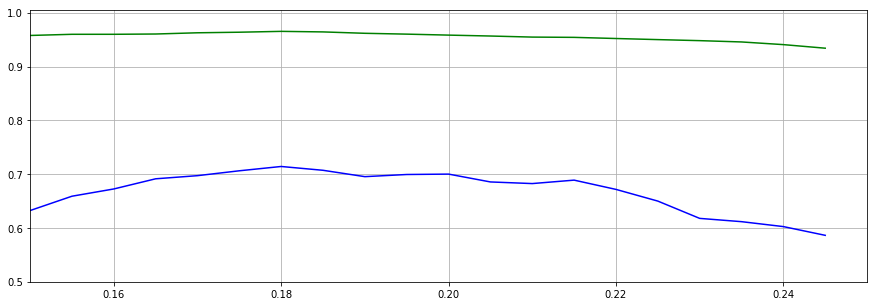

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline  

real = np.array([(r['Threshold'], r['F1']) for r in real_results])
generated = np.array([(r['Threshold'], r['F1']) for r in generated_results])

plt.figure(figsize=(15, 5))
plt.plot(real[:, 0], real[:, 1], c='b')
plt.plot(generated[:, 0], generated[:, 1], c='g')
plt.ylim(0.5, 1.005)
plt.xlim(0.15, 0.25)
plt.grid()
plt.show()

In [14]:
generated_opt_thresh = generated[np.argmax(generated[:, 1])][0]
real_opt_thresh = real[np.argmax(real[:, 1])][0]

opt_f1 = real[np.argmax(real[:, 1])][1]
chosen_f1 = real[np.argmax(generated[:, 1])][1]

print('Real optimal: \t{0:.3f} {1:.4f}'.format(real_opt_thresh, opt_f1))
print('Chosen one: \t{0:.3f} {1:.4f}'.format(generated_opt_thresh, chosen_f1))

Real optimal: 	0.180 0.7143
Chosen one: 	0.180 0.7143


In [94]:
df_1['label_predict'] = df_1['decision_function'] > generated_opt_thresh

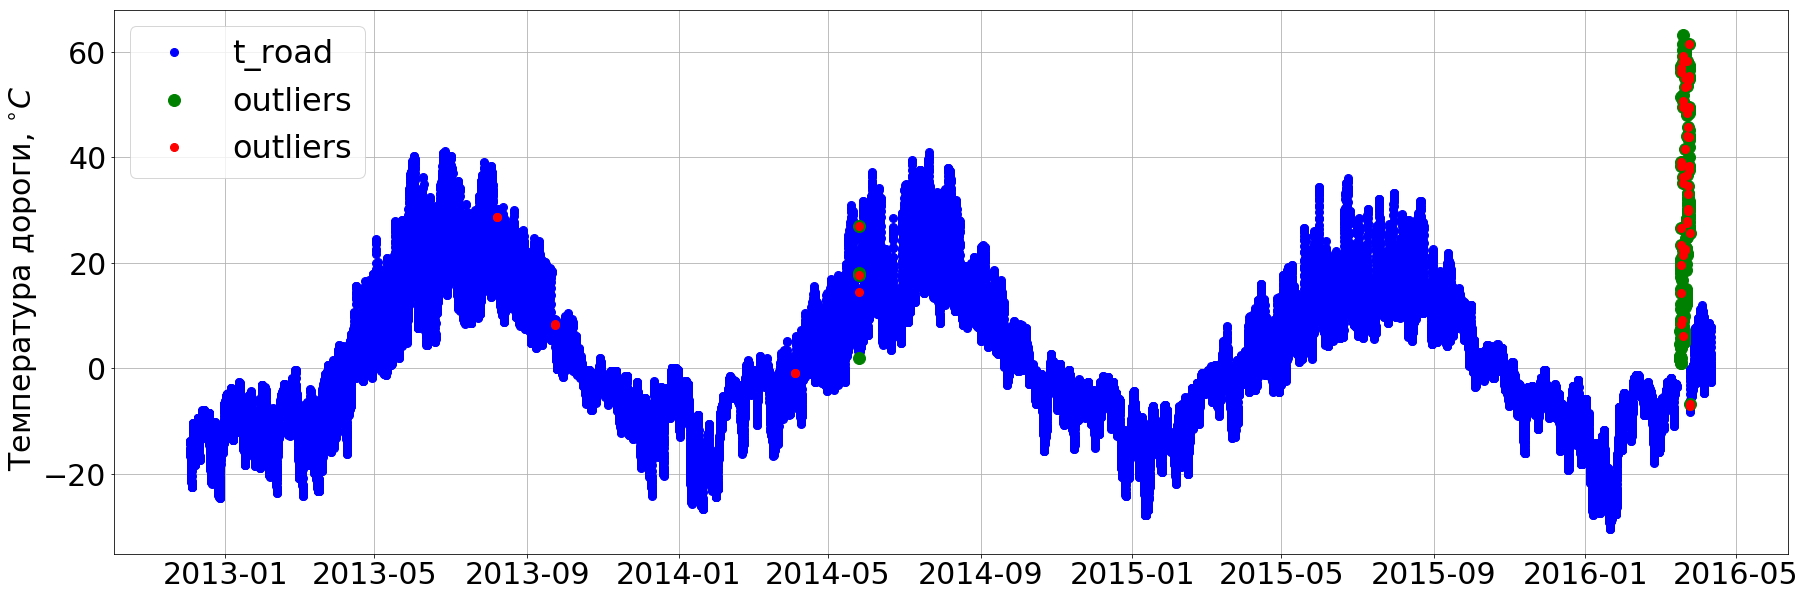

In [95]:
import matplotlib.pyplot as plt

#st_id = [114, 117, 119, 442, 504, 511, 1838, 1896]
#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_1[df_1['station_id']==1896].set_index('date_time_utc'))

start = pd.Timestamp(2012, 12, 1)
end = pd.Timestamp(2017, 2, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()